# **Introduction**

### We often may not know whether the news that comes out every day is true or not. What if there was an artificial intelligence that knew this?
### In this article, we will try to classify whether a news is real or fake news.
### Let's start.

![Açıklama](picture.png)

## Content
1. [Import libraries](#1)
2. [Load Dataset](#2)
3. [Base Analysis](#3)
4. [Data Preprocess](#4)
5. [Create Deep Learning Model](#5)
6. [Evaluate Model Performance](#6)

<a id = "1"></a>
## **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import re
import warnings
warnings.filterwarnings("ignore")
import keras
os.environ["KERAS_BACKEND"] = "tensorflow"
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('punkt')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from keras.models import Model
from keras.layers import Concatenate, Input, Embedding, Conv1D, Dense, Dropout, MaxPooling1D, GlobalMaxPooling1D

In [2]:
keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4050 Laptop GPU, compute capability 8.9


<a id = "2"></a>
## **Load Data**

In [3]:
data = pd.read_csv('news.csv')
data.head(5)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
data.drop(columns=['Unnamed: 0'],inplace=True)

In [5]:
data.head(5)

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 148.6+ KB


<a id='3'></a>
## **Base Analysis**

<font color='green' size='4'><b>When we examine the data, we see the titles and their contents. There is also a column of labels indicating whether it is real or fake. The 'Unnamed: 0' column seems to be determined as id, so it does not carry any information for us. We delete this column.It is also an advantage for us that there are no empty values in our data.</b></font>

<a id='4'></a>
## **Data Preproccess**

<font color='green' size='4'><b>We have come to the most important part. Let's prepare the data before sending the data to our model in the data preprocessing step. First, let's start with a function. Let's remove the punctuation marks from the text data received in the function named 'preprocess_text', convert it to lowercase and find the root meaning of the word. Let's also remove the sections related to grammar.</b></font>

In [7]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d", "", text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    lemmatized_sentence = ' '.join(filtered_tokens)
    return lemmatized_sentence

In [8]:
data.head(2)

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE


In [9]:
data['title'] = data['title'].apply(preprocess_text)
data['text'] = data['text'].apply(preprocess_text)

In [10]:
data.head(2)

,title,text,label
0,smell hillary fear,daniel greenfield shillman journalism fellow f...,FAKE
1,watch exact moment paul ryan committed politic...,google pinterest digg linkedin reddit stumbleu...,FAKE


<font color='green' size='4'><b>Now the 'title' and 'text' columns have become much simpler and understandable for the model. So, which words were used most?
The words with the largest size are the most used words, and the smaller they get, the less used they are.</b></font>

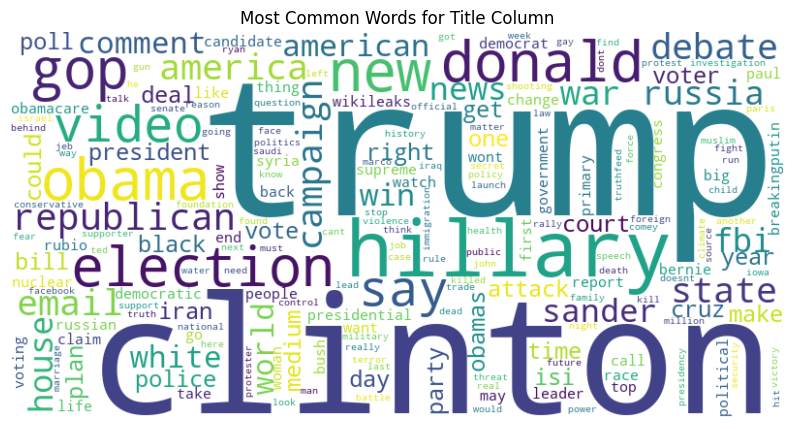

In [11]:
vectorizer =CountVectorizer()
title = vectorizer.fit_transform(data['title'])
word_frequencies_title = title.toarray().sum(axis=0)
word_frequencies_title_dict = {word: freq for word,freq in zip(vectorizer.get_feature_names_out(),word_frequencies_title) }
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies_title_dict)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words for Title Column')
plt.show()

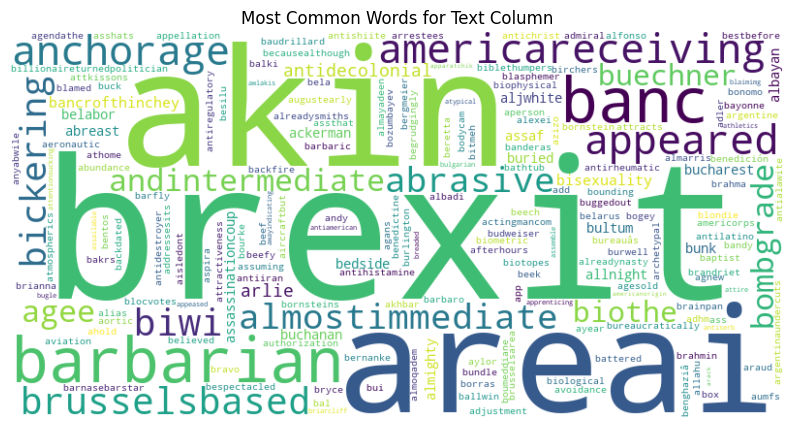

In [12]:
text = vectorizer.fit_transform(data['text'])
word_frequencies_text = title.toarray().sum(axis=0)
word_frequencies_text_dict = {word: freq for word,freq in zip(vectorizer.get_feature_names_out(),word_frequencies_text) }
top_words = sorted(word_frequencies_text_dict.items(), key = lambda x: x[1], reverse=True)[:10]
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies_text_dict)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words for Text Column')
plt.show()

<font color='green' size='4'><b>Since machines love working with numbers the most, we need to switch to a language they can understand. Now we have pre-processed data, let's convert this data into columns of numbers and try to explain ourselves in their language.</b></font>

In [13]:
maxlen = 500
max_words=5000

In [14]:
data['combined_text'] = data['title'] + ' ' + data['text']

In [15]:
data.head(5)

,title,text,label,combined_text
0,smell hillary fear,daniel greenfield shillman journalism fellow f...,FAKE,smell hillary fear daniel greenfield shillman ...
1,watch exact moment paul ryan committed politic...,google pinterest digg linkedin reddit stumbleu...,FAKE,watch exact moment paul ryan committed politic...
2,kerry go paris gesture sympathy,u secretary state john f kerry said monday sto...,REAL,kerry go paris gesture sympathy u secretary st...
3,bernie supporter twitter erupt anger dnc tried...,kaydee king kaydeeking november lesson tonight...,FAKE,bernie supporter twitter erupt anger dnc tried...
4,battle new york primary matter,primary day new york frontrunners hillary clin...,REAL,battle new york primary matter primary day new...


In [16]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['combined_text'])

In [17]:
sequences_title = tokenizer.texts_to_sequences(data['title'])
sequences_text = tokenizer.texts_to_sequences(data['text'])

In [18]:
padded_sequences_title = pad_sequences(sequences_title, maxlen=maxlen)
padded_sequences_text = pad_sequences(sequences_text, maxlen=maxlen)

In [19]:
print('title: ', padded_sequences_title)
print('text: ', padded_sequences_text)

title:  [[   0    0    0 ...    0   17  487]
 [   0    0    0 ...    1  421  205]
 [   0    0    0 ...   76  697 4855]
 ...
 [   0    0    0 ... 1517 2989  210]
 [   0    0    0 ...  115  520 1706]
 [   0    0    0 ...    1 1090  223]]
text:  [[   3 1371  122 ...   19  316  670]
 [   0    0    0 ...  694 1015  538]
 [   0    0    0 ...    8  898  409]
 ...
 [2030 2227 1478 ...  333   38  231]
 [ 542 4750  331 ...  406 1597  919]
 [   0    0    0 ...  668    2    1]]


In [20]:
le = LabelEncoder()

In [21]:
labels = le.fit_transform(data.label)

In [22]:
print(labels)

[0 0 1 ... 0 1 1]


In [23]:
print(le.inverse_transform(np.array(labels[0]).reshape(-1,1)))

['FAKE']


<font color='green' size='4'><b>Now that we've started working with the numbers, let's take a small piece of our data set to train our model and save it for testing. And let's use the rest to train the model.</b></font>

In [24]:
X_train_title, X_test_title, X_train_text, X_test_text, y_train, y_test = train_test_split(padded_sequences_title, padded_sequences_text, labels, test_size=0.1)

In [25]:
X_train_title.shape

(5701, 500)

In [26]:
X_train_title

array([[   0,    0,    0, ...,  996,   46,  103],
       [   0,    0,    0, ..., 1947, 3883,   66],
       [   0,    0,    0, ...,  110, 3763,    1],
       ...,
       [   0,    0,    0, ...,  954,  210,  644],
       [   0,    0,    0, ...,  645,  727, 3129],
       [   0,    0,    0, ...,  203,   50,    7]])

<a id='5'></a>
## **Create Deep Learning Model**

In [27]:
# Define inputs for title and text
input_title = Input(shape=(maxlen,), dtype='int32', name='input_title')
input_text = Input(shape=(maxlen,), dtype='int32', name='input_text')

# Shared embedding layer for both inputs
embedding_layer = Embedding(input_dim=max_words, output_dim=maxlen, input_length=maxlen)

embedded_title = embedding_layer(input_title)
embedded_text = embedding_layer(input_text)

# Convolutional layers for title and text separately
conv1d_layer_title = Conv1D(128, 7, activation='relu', padding='same')(embedded_title)
maxpool_layer_title = MaxPooling1D(5)(conv1d_layer_title)

conv1d_layer_text = Conv1D(128, 7, activation='relu', padding='same')(embedded_text)
maxpool_layer_text = MaxPooling1D(5)(conv1d_layer_text)

# Concatenate the output from convolutional layers
concatenated = Concatenate(axis=1)([maxpool_layer_title, maxpool_layer_text])
global_maxpool = GlobalMaxPooling1D()(concatenated)

# Dense layers and output
dense_layer = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(global_maxpool)
dense_layer2 = Dense(32, activation='relu')(dense_layer)
output = Dense(1, activation='sigmoid')(dense_layer2)

# Define the model with inputs and output
model = Model(inputs=[input_title, input_text], outputs=output)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
# Train the model with X_train_tensor_title and X_train_tensor_text
history = model.fit(
    {'input_title': X_train_title, 'input_text': X_train_text},
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
143/143 [==============================] - 11s 35ms/step - loss: 0.6113 - binary_accuracy: 0.8232 - val_loss: 0.2950 - val_binary_accuracy: 0.9238
Epoch 2/100
143/143 [==============================] - 5s 32ms/step - loss: 0.1796 - binary_accuracy: 0.9667 - val_loss: 0.2474 - val_binary_accuracy: 0.9264
Epoch 3/100
143/143 [==============================] - 5s 32ms/step - loss: 0.0668 - binary_accuracy: 0.9969 - val_loss: 0.2073 - val_binary_accuracy: 0.9299
Epoch 4/100
143/143 [==============================] - 5s 33ms/step - loss: 0.0328 - binary_accuracy: 0.9974 - val_loss: 0.1919 - val_binary_accuracy: 0.9316
Epoch 5/100
143/143 [==============================] - 5s 33ms/step - loss: 0.0154 - binary_accuracy: 0.9993 - val_loss: 0.1815 - val_binary_accuracy: 0.9395
Epoch 6/100
143/143 [==============================] - 5s 33ms/step - loss: 0.0114 - binary_accuracy: 0.9978 - val_loss: 0.1951 - val_binary_accuracy: 0.9387
Epoch 7/100
143/143 [==============================

<a id='6'></a>
## **Evaluate Model**

In [28]:
model.evaluate({'input_title': X_test_title, 'input_text': X_test_text}, y_test, batch_size=32)

20/20 [==============================] - 0s 12ms/step - loss: 0.1887 - binary_accuracy: 0.9385


[0.18868327140808105, 0.9384858012199402]

<font color='green' size='4'><b>Looks like we had 93% success. No bad!
We no longer need to waste our time with fake news, we are only after the truth. :)</b></font>

In [29]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']

In [31]:
epochs = range(1,len(loss)+1)

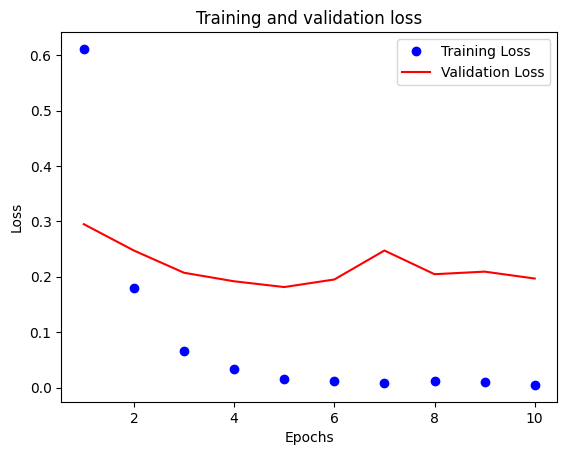

In [32]:
plt.plot(epochs,loss,'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss', color='red')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

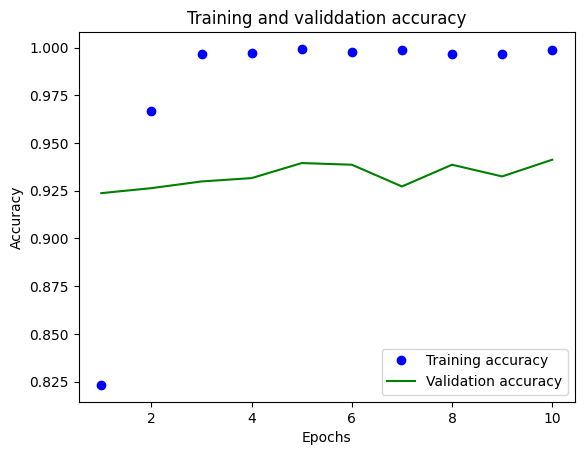

In [33]:
plt.plot(epochs,accuracy,'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy', color='green')
plt.title('Training and validdation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<font size='4'><b>Written by Cihan Borova</b></font>

<font size='3'><b>Dataset = https://www.kaggle.com/datasets/rajatkumar30/fake-news</b></font>